### vision transformer for pytorch

In [1]:
from collections import OrderedDict
from functools import partial
import torch
from torch import nn

## 1. **PatchEmbed 的动机**

在 **NLP** 里，输入是单词序列，每个单词会通过 **embedding** 转换成向量，输入给 Transformer。
但是 **图像**是二维像素矩阵（比如 `224×224×3`），不能直接输入到 Transformer。

于是 ViT 提出了一个办法：
👉 把图像切分成很多小块（patch），再把每个 patch 当作一个“单词”，投影到高维空间，得到 patch embedding。这样图像就被转换成一个序列，能输入 Transformer。

---

## 2. **PatchEmbed 的作用**

`PatchEmbed` 的主要功能是：

1. **切分图像**

   * 输入图像大小：`img_size × img_size × in_c`
   * 划分成 `patch_size × patch_size` 的小块
   * 得到 `num_patches = (img_size / patch_size)²` 个 patch

2. **展平 patch**

   * 每个 patch 展平成一维向量。
   * 原始维度：`patch_size × patch_size × in_c`

3. **线性映射到 embed\_dim**

   * 用 `Linear` 或等效的 `Conv2d` 做投影
   * 每个 patch 最终变成 `embed_dim` 维度的向量

4. **（可选）归一化**

   * 一般在 embedding 后面加 `LayerNorm`，帮助训练稳定

最终输出：

* 一个形状为 `[B, num_patches, embed_dim]` 的 patch embedding 序列，能直接输入 Transformer。

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self,img_size=224,patch_size=16,in_c=3,embed_dim=768,norm_layer=None):
        # img_size 图像大小
        # patch_size 每个patch的大小
        # embed_dim 嵌入的维度
        super().__init__()
        img_size=(img_size,img_size) # 将输入的图像大小变为一个二维元组
        patch_size=(patch_size,patch_size)
        self.img_size=img_size
        self.patch_size=patch_size
        self.gird_size=(img_size[0]//patch_size[0],img_size[1]//patch_size[1]) # patch的网格大小
        self.num_patches=self.gird_size[0]*self.gird_size[1] # patch的数量
        self.proj=nn.Conv2d(in_c,embed_dim,kernel_size=patch_size,stride=patch_size)
        self.norm=norm_layer(embed_dim) if norm_layer else nn.Identity() # 若有layer_norm则使用，若无则保持不变
    def forward(self,x:torch.Tensor):
        B,C,H,W=x.shape # B:batch_size C:channel H:height W:width
        assert H==self.img_size[0] and W==self.img_size[1],f"输入图像的大小与模型期望大小{self.img_size[0]*self.img_size[1]}不匹配"
        x=self.proj(x).flatten(2).transpose(1,2)
        x=self.norm(x) # 若有归一化层则使用
        return x

## 1. **背景**

在 ViT 里，图像被切分成 patch（比如 196 个 patch），每个 patch 都被嵌入成一个向量。
Transformer 的核心就是 **Attention 机制**，它能让这些 patch 之间建立联系：

* 哪些 patch 更相关
* 如何把全局信息融合

在 ViT 中，主要使用的是 **多头自注意力 (Multi-Head Self-Attention, MHSA)**。

---

## 2. **Attention 的基本思想**

对于输入序列 \$X \in \mathbb{R}^{N \times d}\$ （\$N\$ = patch 数，\$d\$ = embedding 维度）：
Attention 会学习不同 patch 之间的依赖关系。

**步骤：**

1. **投影成 Q, K, V**

   * \$Q = XW\_Q,\ K = XW\_K,\ V = XW\_V\$
   * 其中 \$W\_Q, W\_K, W\_V \in \mathbb{R}^{d \times d\_h}\$ 是可学习参数

2. **计算注意力分数**

   * \$A = \text{softmax}\left(\frac{QK^T}{\sqrt{d\_h}}\right)\$
   * 表示每个 patch 对其他 patch 的关注程度

3. **加权求和得到输出**

   * \$O = AV\$
   * 每个 patch 的新表示是所有 patch 信息的加权和

---

## 3. **多头机制 (Multi-Head)**

单头可能只学到一种关系，所以 ViT 使用 **多头 (Multi-Head)**：

* 输入向量被分成多个子空间（head）
* 每个 head 单独做 Attention
* 最后拼接起来，再通过线性层融合

公式：

$$
\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

## 1. **为什么不是 N = num\_patch，而是 num\_patch + 1？**

在 ViT 里，除了 patch embedding 外，还会额外引入一个 **class token**，所以总长度比 patch 数多 1。

---

## 2. **class token 的作用**

* 类似于 NLP 里 BERT 的 `[CLS]` token。
* 它是一个可学习的向量（参数），在序列最前面拼接到所有 patch embedding 前面：

$$
X = [x_{cls}, x_1, x_2, \dots, x_{num\_patch}]
$$

* Transformer 在多层 Attention 后，会更新所有向量，其中 `x_cls` 聚合了整个图像的信息。
* 最后分类时，只取 `x_cls` 的输出送入分类头 (MLP Head)。

In [ ]:
class Attention(nn.Module):
    def __init__(self,dim,num_heads=8,qkv_bais=False,qk_scale=None,atte_drop_ration=0,proj_drop_ration=0):
        # dim 输入的token维度，768
        # num_heads 注意力头数，为8
        # qkv_scale 生成qkv的时候是否添加偏置
        # qkv_scale 用于缩放qk的系数，如果是None,则使用1/sqrt(embed_dim_pre_head)
        # atte_drop_out 注意力分数的dropout的比率，防止过拟合
        # proj_drop_ration 最终投影层的dropout的比率
        super().__init__()
        self.num_heads=num_heads # 注意力头数
        head_dim=dim//num_heads # 每个注意力头的维族
        self.scale=qk_scale or head_dim**-0.5
        self.qkv=nn.Linear(dim,dim*3,bias=qkv_bais) # 通过全连接层生成qkv,为了并行运算，提高计算效率，参数更好
        self.att_drop=nn.Dropout(p=atte_drop_ration)
        self.proj_drop=nn.Dropout(proj_drop_ration)
        # 将每个head得到的输出进行concat拼接，然后通过线性变换映射回原来的嵌入dim
        self.proj=nn.Linear(dim,dim)
    def forward(self,x:torch.Tensor):
        B,N,C=x.shape # B: batch_size N: num_patch+1 C:embed_dim
        # qkv(B,N,3*C)=>(B,N,3,num_heads,c//self.num_heads)
        qkv=self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2,0,3,1,4) # 方便做运算
        q,k,v=qkv[0],qkv[1],qkv[2]
        # 计算qk的点击，并进行缩放，得到注意力分数
        attn=torch.matmul(q,k.transpose(-2,-1))*self.scale
        attn=attn.softmax(dim=-1) # 对每行进行softmax
        # 注意力权重对v进行加权求和
        # att@v: (B,num_heads,N,c//self.num_heads)
        # transpose: (B,N,self.num_heads,c//self.num_heads)
        # reshape:(B,N,C)将最后两个维度信息拼接，合并多个头输出，回到总的嵌入维度
        o=torch.matmul(attn,v).transpose(1,2).reshape(B,N,C)
        o=self.proj(o)
        o=self.proj_drop(x) # 防止过拟合
        return o

In [ ]:
class MLP(nn.Module):
    def __init__(self,in_features,hidden_features=None,out_features=None,act_layer=nn.GELU,drop=0):
        # in_features 输入法维度
        # hidden_features 隐藏层的维度，通常为in_features的4倍，out_features维度通常与ib_features相等
        super().__init__()
        out_features=out_features or in_features
        hidden_features= hidden_features or in_features
        self.fc1=nn.Linear(in_features,hidden_features)
        self.act=act_layer()
        self.fc2=nn.Linear(hidden_features,out_features)
        self.drop=nn.Dropout(p=drop)
    def forward(self,x):
        x=self.fcq(x) # 第一个全连接层
        x=self.act(x) # 激活函数
        x=self.drop(x) # 丢弃一些神经元，防止过拟合
        x=self.fc2(x)
        x=self.drop(x)
        return x

## **Block 的公式**

假设输入序列为 \$x \in \mathbb{R}^{N \times d}\$：

1. **自注意力层**

   $$
   x' = x + \text{MSA}(\text{LN}(x))
   $$

2. **前馈网络层**

   $$
   x'' = x' + \text{MLP}(\text{LN}(x'))
   $$

其中：

* `LN` = LayerNorm
* `MSA` = Multi-Head Self-Attention
* `MLP` = 两层全连接网络 + 激活函数 (通常是 GELU)
* 残差连接保证梯度稳定，防止深层训练困难

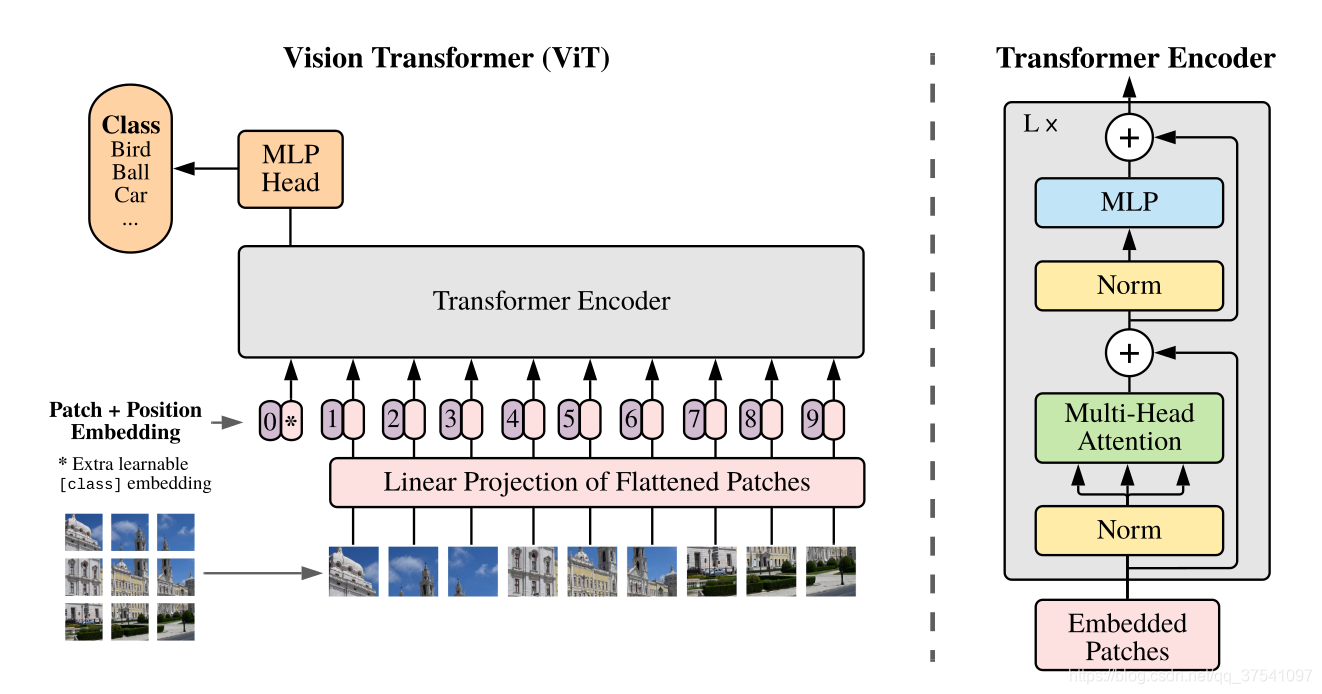

In [ ]:
def drop_path(x:torch.Tensor,drop_prod:float=0.,training:bool=False):
    if drop_prod==0. or not training: # 如果丢弃为0，或者不处于训练状态，直接返回原始输入
        return x
    keep_prof=1-drop_prod # 保持路径的概率
    shape=(x.shape[0],1,x.ndim-1) # 生成与x的维度匹配的形状，只保持batch维度
    random_tensor=keep_prof+torch.rand(shape,dtype=x.dtype,device=x.device) # 生成一个与x大小相同的随机张量
    random_tensor.floor_() # 将随机张量二值化
    output=x.div(keep_prof)*random_tensor # 将输入张量x缩放并与随机张量相除，实现部分路径丢弃
    return output # 返回经过drop path 操作后的张量

In [ ]:
class DropPath(nn.Module):
    def __init__(self,drop_prob,training:bool=True):
        super().__init__()
        self.drop_prob=drop_prob
        self.training=training
    def forward(self,x):
        return drop_path(x,self.drop_prob,self.training)

In [ ]:
class Block(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio=4,qkv_bias=False,qkv_scale=None,drop_ratio=0,attn_drop_ratio=0,dorp_path_ratio=0,act_layer=nn.GELU,norm_layer=nn.LayerNorm):
        # dim每一个token的维度
        # num_heads 都头注意力的头数
        # mlp_ratio 计算hidden_features大小为输入的4倍
        # act_ratio 激活函数
        # norm_layer 正则化层
        # attn_drop_ratio 生成qkv后的dropout
        # drop_path_ratio drop_path的比例
        # drop_ratio 多头注意力机制最后发linear后使用的dropout
        super().__init__()
        self.norm1=norm_layer(dim)
        # 实例化多头注意力机制
        self.attn=Attention(dim,num_heads,qkv_bias,qkv_scale,attn_drop_ratio,drop_ratio)
        # 如果drop——prob不大于零不做任何更改
        self.drop_path=DropPath(drop_prob=dorp_path_ratio) if dorp_path_ratio>0 else nn.Identity
        self.norm2=norm_layer(dim) # 第二个layer_norm
        mlp_hidden_dim=int(dim*mlp_ratio)
        # 定义mlp层
        self.mlp=MLP(in_features=dim,hidden_features=mlp_hidden_dim,act_layer=act_layer,drop=drop_ratio)
    def forward(self,x):
        # 前向传播
        x=x+self.drop_path(self.attn(self.norm1(x))) # drop_path不份论文并没有指出
        x=x+self.drop_path(self.mlp(self.norm2(x)))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self,img_size=224,patch_size=16,num_classes=1000,in_c=3,embed_idm=768,depth=12,num_heads=12,mlp_ratio=4,qkv_bias=True,qk_scale=None,representation_size=None,distilled=False,drop_ratio=0,attn_drop_ratio=0,drop_path_ratio=0,embed_layer=PatchEmbed,norm_layer=None,act_layer=None):
        super().__init__()
        self.num_classes=num_classes
        self.num_features=self.num_classes
        self.num_tokens=2 if distilled else 1
        norm_layer=norm_layer or partial(nn.LayerNorm,eps=1e-6)
        act_layer=act_layer or nn.GELU()
        self.patch_embed=embed_layer(img_size,patch_size,in_c,embed_idm)
        num_patches=self.patch_embed.num_patches
        # 使用nn.Paramers构建可以训练的参数，使用零初始化，第一个是batch_size
        self.cls_token=nn.Parameter(torch.zeros(1,1,embed_idm))
        self.dist_token=nn.Parameter(torch.zeros(1,1,embed_idm)) if distilled else None
        # position_embeding大小与concta拼接后的大小一致
        self.pos_embed=nn.Parameter(torch.zeros(1,num_patches+self.num_tokens,embed_idm))
        self.pos_drop=nn.Dropout(p=drop_ratio)
        dgr=[x.item() for x in torch.linspace(0,drop_path_ratio,depth)]
        self.block=nn.Sequential(*[
            Block(embed_idm,num_heads,mlp_ratio,qkv_bias,qk_scale,drop_ratio,attn_drop_ratio,dgr[i],norm_layer,act_layer) for i in range(len(depth))
        ])
        self.norm=norm_layer(embed_idm) # transformer后的norm_layer
        if representation_size and not distilled:
            self.has_logits=True
            self.num_features=representation_size
            self.pre_logits=nn.Sequential(OrderedDict([
                ("fc",nn.Linear(embed_idm,representation_size)),
                ("act",nn.Tanh()),
            ]))
        else:
            self.has_logits=False
            self.pre_logits=nn.Identity() # 不做任何处理
        self.head=nn.Linear(self.num_features,num_classes) if num_classes>0 else nn.Identity()
        if distilled:
            self.head_dist=nn.Linear(embed_idm,self.num_classes) if num_classes>0 else nn.Identity()
        # 权重初始化
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token,std=0.02)
        nn.init.trunc_normal_(self.cls_token,std=0.02)
        self.apply(_init_vit_weight)
    def forward_features(self,x):
        x=self.patch_embed(x)
